<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import h2o
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator

# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,sklearn,matplotlib,h2o

Ethen 2018-06-02 20:50:45 

CPython 3.6.4
IPython 6.3.1

numpy 1.14.3
pandas 0.23.0
sklearn 0.19.1
matplotlib 2.2.2
h2o 3.18.0.8


In [2]:
h2o.init(max_mem_size='2G')

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_161"; Java(TM) SE Runtime Environment (build 1.8.0_161-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.161-b12, mixed mode)
  Starting server from /Users/mingyuliu/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/b6/fy5cl70s7nq6g7275rkdpd6m3967fj/T/tmpl9cnfe8n
  JVM stdout: /var/folders/b6/fy5cl70s7nq6g7275rkdpd6m3967fj/T/tmpl9cnfe8n/h2o_mingyuliu_started_from_python.out
  JVM stderr: /var/folders/b6/fy5cl70s7nq6g7275rkdpd6m3967fj/T/tmpl9cnfe8n/h2o_mingyuliu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.8
H2O cluster version age:,1 month and 14 days
H2O cluster name:,H2O_from_python_mingyuliu_54hnty
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [11]:
path = 'default of credit card clients.xls'
data = pd.read_excel(path,
                     skiprows=1)

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'})
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [12]:
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [13]:
def recode_data(data):
    """ Recodes numeric categorical variables into categorical character variables
    with more transparent values. 

    Args:
        data: Pandas DataFrame version of UCI credit card default data.

    Returns: 
        H2OFrame with recoded values.
    """

    # define recoded values
    sex_dict = {1:'male', 2:'female'}
    education_dict = {0:'other', 1:'graduate school', 2:'university', 3:'high school', 
                      4:'other', 5:'other', 6:'other'}
    marriage_dict = {0:'other', 1:'married', 2:'single', 3:'divorced'}
    pay_dict = {-2:'no consumption', -1:'pay duly', 0:'use of revolving credit', 1:'1 month delay', 
                2:'2 month delay', 3:'3 month delay', 4:'4 month delay', 5:'5 month delay', 6:'6 month delay', 
                7:'7 month delay', 8:'8 month delay', 9:'9+ month delay'}

    # recode values using Pandas apply() and anonymous function
    data['SEX'] = data['SEX'].map(sex_dict)
    data['EDUCATION'] = data['EDUCATION'].map(education_dict)
    data['MARRIAGE'] = data['MARRIAGE'].map(marriage_dict)    
    for name in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
        data[name] = data[name].map(pay_dict)

    return h2o.H2OFrame(data)


data = recode_data(data)
data.head()

/Users/mingyuliu/anaconda3/lib/python3.6/site-packages/h2o/utils/shared_utils.py:170: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%


ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
1,20000,female,university,married,24,2 month delay,2 month delay,pay duly,pay duly,no consumption,no consumption,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,female,university,single,26,pay duly,2 month delay,use of revolving credit,use of revolving credit,use of revolving credit,2 month delay,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,female,university,single,34,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,female,university,married,37,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,male,university,married,57,pay duly,use of revolving credit,pay duly,use of revolving credit,use of revolving credit,use of revolving credit,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,50000,male,graduate school,single,37,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,0
7,500000,male,graduate school,single,29,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
8,100000,female,university,single,23,use of revolving credit,pay duly,pay duly,use of revolving credit,use of revolving credit,pay duly,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0
9,140000,female,high school,married,28,use of revolving credit,use of revolving credit,2 month delay,use of revolving credit,use of revolving credit,use of revolving credit,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,0
10,20000,male,high school,single,35,no consumption,no consumption,no consumption,no consumption,pay duly,pay duly,0,0,0,0,13007,13912,0,0,0,13007,1122,0,0


In [14]:
data[y] = data[y].asfactor()
data.describe()

Rows:30000
Cols:25




,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
type,int,int,enum,enum,enum,int,enum,enum,enum,enum,enum,enum,int,int,int,int,int,int,int,int,int,int,int,int,enum
mins,1.0,10000.0,,,,21.0,,,,,,,-165580.0,-69777.0,-157264.0,-170000.0,-81334.0,-339603.0,0.0,0.0,0.0,0.0,0.0,0.0,
mean,15000.5,167484.32266666688,,,,35.48549999999994,,,,,,,51223.33090000009,49179.07516666668,47013.15479999971,43262.9489666666,40311.40096666653,38871.76039999991,5663.580500000014,5921.16350000001,5225.681500000005,4826.076866666661,4799.387633333302,5215.502566666664,
maxs,30000.0,1000000.0,,,,79.0,,,,,,,964511.0,983931.0,1664089.0,891586.0,927171.0,961664.0,873552.0,1684259.0,896040.0,621000.0,426529.0,528666.0,
sigma,8660.398374208891,129747.66156720225,,,,9.21790406809016,,,,,,,73635.86057552959,71173.76878252836,69349.38742703681,64332.85613391641,60797.1557702648,59554.10753674574,16563.280354025763,23040.870402057226,17606.961469803115,15666.159744031993,15278.305679144793,17777.465775435332,
zeros,0,0,,,,0,,,,,,,2008,2506,2870,3195,3506,4020,5249,5396,5968,6408,6703,7173,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1.0,20000.0,female,university,married,24.0,2 month delay,2 month delay,pay duly,pay duly,no consumption,no consumption,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2.0,120000.0,female,university,single,26.0,pay duly,2 month delay,use of revolving credit,use of revolving credit,use of revolving credit,2 month delay,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3.0,90000.0,female,university,single,34.0,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0


In [15]:
train, test = data.split_frame([0.7], seed=12345)

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 21060, columns = 25
Test data rows = 8940, columns = 25


In [16]:
#9 - initialize GBM model
model = H2OGradientBoostingEstimator(ntrees=150,            # maximum 150 trees in GBM
                                     max_depth=4,           # trees can have maximum depth of 4
                                     sample_rate=0.9,       # use 90% of rows in each iteration (tree)
                                     col_sample_rate=0.9,   # use 90% of variables in each iteration (tree)
                                     stopping_rounds=5,     # stop if validation error does not decrease for 5 iterations (trees)
                                     score_tree_interval=1, # for reproducibility, set higher for bigger data
                                     seed=12345)            # random seed for reproducibility

# train a GBM model
model.train(y=y, x=X, training_frame=train, validation_frame=test)

# print AUC
print('GBM Test AUC = %.2f' % model.auc(valid=True))

gbm Model Build progress: |███████████████████████████████████████████████| 100%
GBM Test AUC = 0.78


In [17]:
row = test[test['ID'] == 29116]
row

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
29116,20000,female,university,married,59,3 month delay,2 month delay,3 month delay,2 month delay,2 month delay,4 month delay,8803,11137,10672,11201,12721,11946,2800,0,1000,2000,0,0,1


In [18]:
test[X].types

{'LIMIT_BAL': 'int',
 'SEX': 'enum',
 'EDUCATION': 'enum',
 'MARRIAGE': 'enum',
 'AGE': 'int',
 'PAY_0': 'enum',
 'PAY_2': 'enum',
 'PAY_3': 'enum',
 'PAY_4': 'enum',
 'PAY_5': 'enum',
 'PAY_6': 'enum',
 'BILL_AMT1': 'int',
 'BILL_AMT2': 'int',
 'BILL_AMT3': 'int',
 'BILL_AMT4': 'int',
 'BILL_AMT5': 'int',
 'BILL_AMT6': 'int',
 'PAY_AMT1': 'int',
 'PAY_AMT2': 'int',
 'PAY_AMT3': 'int',
 'PAY_AMT4': 'int',
 'PAY_AMT5': 'int',
 'PAY_AMT6': 'int'}

In [38]:
def generate_local_sample(row, frame, X, N=1000, random_state=11111):

    """ Generates a perturbed sample around a row of interest.

    Args:
        row: Row of H2OFrame to be explained.
        frame: H2OFrame in which row is stored.
        X: List of model input variables.
        N: Number of samples to generate.

    Returns:
        Pandas DataFrame containing perturbed sample.

    """

    # initialize Pandas DataFrame
    sample_frame = pd.DataFrame(data=np.zeros(shape=(N, len(X))), columns=X)

    # generate column vectors of 
    # randomly drawn levels for categorical variables
    # normally distributed numeric values around mean of column for numeric variables
    rstate = np.random.RandomState(11111)
    for key, val in frame[X].types.items():
        if val == 'enum': # 'enum' means categorical
            # draw = rstate.choice(frame[key].levels()[0], size=(1, N))[0]
            
            # TODO sample according to the distribution of the levels as oppose to uniform
            draw = rstate.choice(frame[key].levels()[0], size=N)
        else:
            # TODO discretize the numerical features
            loc = row[key][0, 0]
            scale = frame[key].sd()
            draw = rstate.normal(loc, scale, size=N)
            draw[draw < 0] = loc # prevents unrealistic values when std. dev. is large ???

        sample_frame[key] = draw

    return sample_frame

# run and display results
perturbed_sample = generate_local_sample(row, test, X)
perturbed_sample.head(n=3)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,9988.454213,female,university,other,51.496293,1 month delay,pay duly,5 month delay,4 month delay,6 month delay,...,10672.0,121289.851945,1114.599376,11946.000000,18735.107977,0.000000,12211.659309,30245.153631,13731.108106,0.000000
1,181039.642122,female,graduate school,divorced,55.864325,1 month delay,5 month delay,8 month delay,3 month delay,use of revolving credit,...,10672.0,11201.000000,12721.000000,40285.551857,28422.126086,1556.832579,3606.956154,2000.000000,4969.262205,0.000000
2,20000.000000,female,university,single,43.888241,4 month delay,pay duly,3 month delay,2 month delay,use of revolving credit,...,10672.0,11201.000000,12721.000000,6071.637003,2800.000000,13352.135873,20747.475671,2453.351213,23845.689804,8155.028199


In [39]:
numeric = list(set(X) - set(['ID', 'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2',
                             'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'DEFAULT_NEXT_MONTH']))

scaled_test = test.as_data_frame()
scaled_test[numeric] = (scaled_test[numeric] - scaled_test[numeric].mean())/scaled_test[numeric].std()

# encode categorical
row_df = scaled_test[scaled_test['ID'] == 22760]
row_dummies = pd.concat([row_df.drop(['ID', 'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2',
                                      'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'DEFAULT_NEXT_MONTH'], axis=1),
                        pd.get_dummies(row_df[['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0',
                                               'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']])], 
                        axis=1)

# convert to H2OFrame
row_dummies = h2o.H2OFrame(row_dummies)
row_dummies

/Users/mingyuliu/anaconda3/lib/python3.6/site-packages/h2o/utils/shared_utils.py:170: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%


LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_female,EDUCATION_graduate school,MARRIAGE_married,PAY_0_3 month delay,PAY_2_2 month delay,PAY_3_2 month delay,PAY_4_3 month delay,PAY_5_3 month delay,PAY_6_3 month delay
2.24639,0.481433,-0.66112,-0.657958,-0.651883,-0.637776,-0.622867,-0.609179,-0.360791,-0.282325,-0.315203,-0.319038,-0.319074,-0.270536,1,1,1,1,1,1,1,1,1


In [40]:
scaled_perturbed_sample = perturbed_sample[numeric].copy(deep=True)
scaled_perturbed_sample = (scaled_perturbed_sample - scaled_perturbed_sample.mean())/scaled_perturbed_sample.std()

# encode
perturbed_sample_dummies = pd.concat([scaled_perturbed_sample,
                                      pd.get_dummies(perturbed_sample[['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0',
                                                                       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']])],
                                     axis=1)

# convert to H2OFrame
perturbed_sample_dummies = h2o.H2OFrame(perturbed_sample_dummies[row_dummies.columns])
perturbed_sample_dummies.head(rows=3)

/Users/mingyuliu/anaconda3/lib/python3.6/site-packages/h2o/utils/shared_utils.py:170: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%


LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_female,EDUCATION_graduate school,MARRIAGE_married,PAY_0_3 month delay,PAY_2_2 month delay,PAY_3_2 month delay,PAY_4_3 month delay,PAY_5_3 month delay,PAY_6_3 month delay
-0.845634,-0.838269,-0.663615,-0.683519,-0.676964,2.16259,-0.986601,-0.656564,1.03095,-0.689569,0.439378,2.51141,0.890709,-0.67965,1,0,0,0,0,0,0,0,0
1.41903,-0.363634,-0.796014,-0.683519,-0.676964,-0.678617,-0.662622,0.154721,2.08122,-0.560312,-0.40753,-0.686232,-0.102464,-0.67965,1,1,0,0,0,0,1,0,0
-0.713084,-1.66497,-0.736767,0.965259,-0.676964,-0.678617,-0.662622,-0.824731,-0.696747,0.418996,1.27951,-0.634908,2.03722,0.0925187,1,0,0,0,0,0,0,0,0


In [41]:
# convert distance to similarity
distance = row_dummies.distance(perturbed_sample_dummies, measure='l2').transpose()
distance.columns = ['distance']          # rename 
distance = distance.max() - distance     # lower distances, higher weight in LIME
distance.head(rows=3)

distance
41.2387
66.43
47.8454


In [42]:
perturbed_sample = h2o.H2OFrame(perturbed_sample).cbind(distance)
perturbed_sample.head(rows=3)

/Users/mingyuliu/anaconda3/lib/python3.6/site-packages/h2o/utils/shared_utils.py:170: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%


LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,distance
9988.45,female,university,other,51.4963,1 month delay,pay duly,5 month delay,4 month delay,6 month delay,pay duly,8803,11137,10672,121290,1114.6,11946,18735.1,0,12211.7,30245.2,13731.1,0,41.2387
181040,female,graduate school,divorced,55.8643,1 month delay,5 month delay,8 month delay,3 month delay,use of revolving credit,8 month delay,3339.57,11137,10672,11201,12721,40285.6,28422.1,1556.83,3606.96,2000,4969.26,0,66.43
20000,female,university,single,43.8882,4 month delay,pay duly,3 month delay,2 month delay,use of revolving credit,2 month delay,5784.4,80513.4,10672,11201,12721,6071.64,2800,13352.1,20747.5,2453.35,23845.7,8155.03,47.8454


In [43]:
yhat = 'p_DEFAULT_NEXT_MONTH'
preds1 = model.predict(perturbed_sample).drop(['predict', 'p0'])
preds1.columns = [yhat]
perturbed_sample = perturbed_sample.cbind(preds1)
perturbed_sample.head(rows=3)

gbm prediction progress: |████████████████████████████████████████████████| 100%


LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,distance,p_DEFAULT_NEXT_MONTH
9988.45,female,university,other,51.4963,1 month delay,pay duly,5 month delay,4 month delay,6 month delay,pay duly,8803,11137,10672,121290,1114.6,11946,18735.1,0,12211.7,30245.2,13731.1,0,41.2387,0.252091
181040,female,graduate school,divorced,55.8643,1 month delay,5 month delay,8 month delay,3 month delay,use of revolving credit,8 month delay,3339.57,11137,10672,11201,12721,40285.6,28422.1,1556.83,3606.96,2000,4969.26,0,66.43,0.410367
20000,female,university,single,43.8882,4 month delay,pay duly,3 month delay,2 month delay,use of revolving credit,2 month delay,5784.4,80513.4,10672,11201,12721,6071.64,2800,13352.1,20747.5,2453.35,23845.7,8155.03,47.8454,0.546289


In [44]:
local_glm1 = H2OGeneralizedLinearEstimator(lambda_search=True, 
                                           weights_column='distance',
                                           seed=12345)
# train 
local_glm1.train(x=X, y=yhat, training_frame=perturbed_sample)

# coefs
print('\nLocal Positive GLM Coefficients:')
for c_name, c_val in sorted(local_glm1.coef().items(), key=operator.itemgetter(1)):
    if c_val > 0.0:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))

# r2
print('\nLocal GLM R-square:\n%.2f' % local_glm1.r2())

glm Model Build progress: |███████████████████████████████████████████████| 100%

Local Positive GLM Coefficients:
BILL_AMT6:                1.8373231552251264e-09
BILL_AMT2:                2.5463716488008177e-08
BILL_AMT5:                8.76388273970684e-08
PAY_AMT1:                 8.788976053951531e-08
BILL_AMT3:                1.220860229987731e-07
BILL_AMT4:                3.0326990669470214e-07
AGE:                      0.00015714032948282864
SEX.male:                 0.00031464131168665766
PAY_4.8 month delay:      0.0003578282694683252
PAY_4.no consumption:     0.0014953342642140752
MARRIAGE.divorced:        0.0018428113770639655
PAY_3.4 month delay:      0.0018647341153956501
PAY_3.8 month delay:      0.0031521710531953427
PAY_3.7 month delay:      0.005953078234296301
PAY_5.6 month delay:      0.007025455906050792
PAY_3.2 month delay:      0.008682730694864204
PAY_5.8 month delay:      0.01054672786923973
EDUCATION.graduate school: 0.014919465964416432
PAY_5.2 month delay:  

In [45]:
def plot_local_contrib(row, model, X): 

    """ Plots reason codes in a bar chart. 

    Args:

        row: Row of H2OFrame to be explained.
        model: H2O linear model used for generating reason codes.
        X: List of model input variables.

    """

    # initialize Pandas DataFrame to store results
    local_contrib_frame = pd.DataFrame(columns=['Name', 'Local Contribution', 'Sign'])

    # multiply values in row by local glm coefficients    
    for key, val in sorted(row[X].types.items()):
        contrib = 0
        name = ''
        if val == 'enum':
                level = row[key][0, 0]
                name = '.'.join([str(key), str(level)])
                if name in model.coef():
                    contrib = model.coef()[name]
        else:
            name = key
            if name in model.coef():
                contrib = row[name][0, 0]*model.coef()[name]

        # save only non-zero values
        if contrib != 0.0:
            local_contrib_frame = local_contrib_frame.append({'Name': name,
                                                              'Local Contribution': contrib,
                                                              'Sign': contrib > 0}, 
                                                             ignore_index=True) 

    # plot
    _ = local_contrib_frame.plot(x='Name',
                                 y='Local Contribution',
                                 kind='bar', 
                                 title='Reason Codes', 
                                 color=''.join(local_contrib_frame.Sign.map({True:'b', False:'g'}).values), 
                                 legend=False)

ValueError: Invalid RGBA argument: 'bgbbbbbgbbbbbbbbggg'

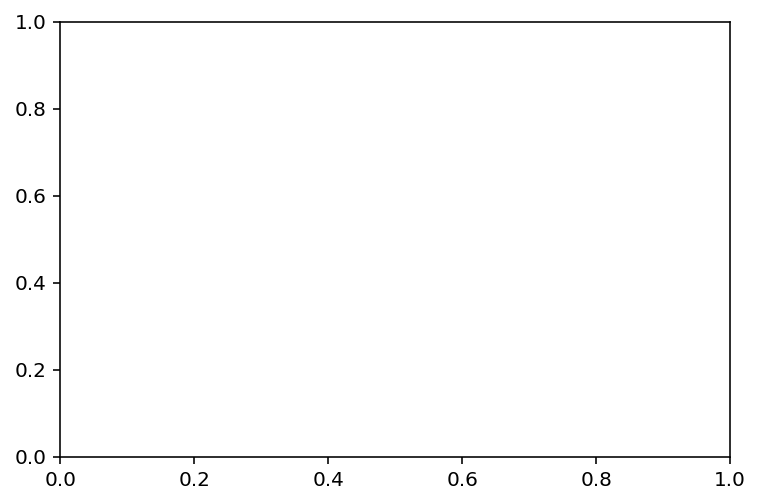

In [46]:
plot_local_contrib(row, local_glm1, X)